# Solving steady-state flow with a graph-based DFN structure

### Problem statement
We propose a method to quickly estimate flow in a DFN and to avoid the computational burden associated with DFN meshing and flow solving. The method consists in solving steady-state flow on a graph-based structure equivalent to the DFN. Two structures are possible: a graph of fractures and a graph of intersections. Both are presented in this tutorial.

<center>
<div>
<img src="https://gitlab.com/fractorylab/dfnlab/-/raw/master/Tutorials/img/graph_flow.png" width="800"/>
</div>
<br>
Solving flow using graphs instead of a mesh
</center>

### Theoretical background
The complex multiscale nature of fracture networks plays a key role in their flowing properties.
<br>
<br>
Graphs are mathematical objects made of nodes and edges that aim at studying complex systems ([Barabási et al.](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.74.47)). They lend themselves to the simplification of fracture networks by preserving their complex structure ([Andresen et al.](https://www.frontiersin.org/articles/10.3389/fphy.2013.00007/full))
<br>
<br>
However, graph-based representations have difficulties to preserve fracture flowing properties because fracture planes are replaced by one-dimensional edges. [Doolaeghe et al. (2020)](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.102.053312)  propose edge conductance definition equivalent to the one of a fracture with constant aperture, for the two following graph-based DFN models:
- a fracture graph, where nodes represent fractures and edges exist between intersecting fractures 
- an intersection graph, where nodes represent intersections, and edges represent the fracture plane connecting two intersections. <br>

[Doolaeghe et al. (2020)](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.102.053312) show that these conductance definitions can be used to solve flow with a graph and estimate DFN flow properties.

The graph flow solving method can be found in [Karra et al.](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.97.033304).

### What will you learn ?
- Creating a fracture graph and an intersection graph from a DFN (see Theoretical background). 
- Solving the flow with a fracture graph and intersection graph.
- Recovering flow results with post-process indicators: DFN equivalent permeability, flow by fracture, flow by intersection.
- Visualisation of the solution.

### DFN.Lab model

This tutorial is focused on the module __Graphs__.<br/>

In [1]:
import dfnlab.Graphs as graphs

_____________

## Graph construction from a DFN

First, we initialize the system, made of a cubic domain and import a DFN.

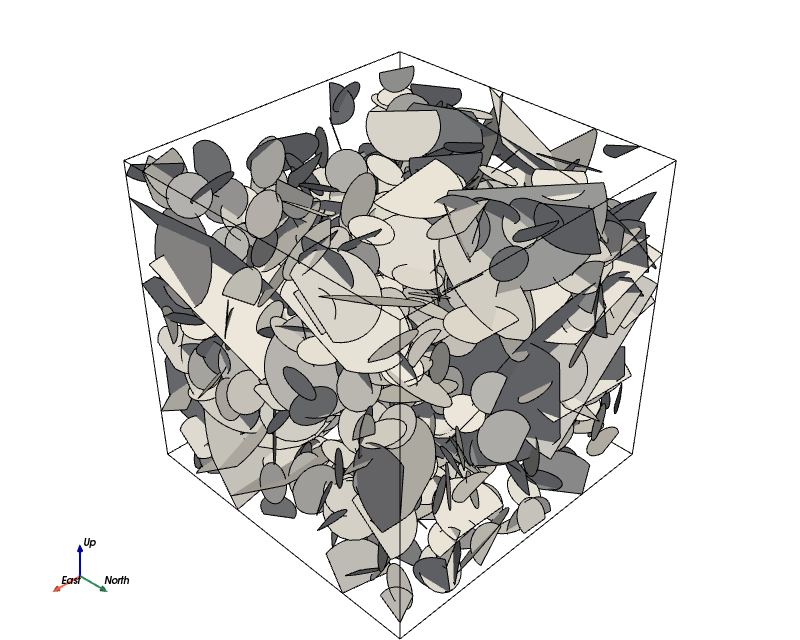

Number of fractures in dfn = 652


In [2]:
import dfnlab.System as sys
import dfnlab.Domains as dom
import dfnlab.Fractures as dfn
import dfnlab.Generator as gen
import dfnlab.IO as io
import os 

system = sys.System()
domain = dom.Domain()
domain.buildParallelepiped(center=[0, 0, 0], L1=10.)
system.setDomain(domain)
fnet = dfn.DFN()
system.setDFN(fnet)
io.load_DFN_file(fnet,filename='sources/dfn_for_graphs.disk', format="disk")
system.build()

from sources.functions import plot_dfn
plot_dfn(system)
print("Number of fractures in dfn = {}".format(fnet.numFractures())) 

We create a fracture graph from the system.
In addition to the fracture nodes, nodes are automatically added for each intersection between fractures and domain borders or geometries.

Number of nodes in fgraph = 879


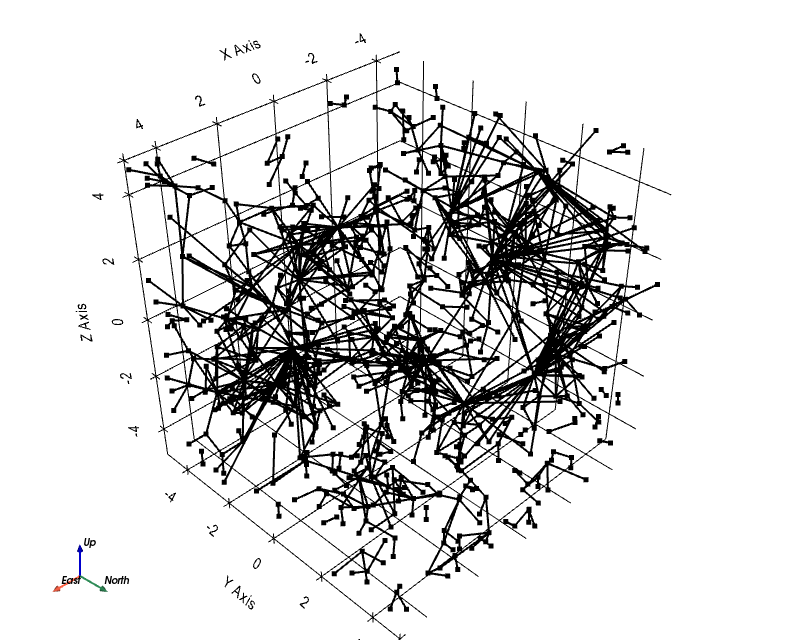

In [3]:
fgraph = graphs.FractureGraph()
fgraph.create(system)
print("Number of nodes in fgraph = {}".format(fgraph.numVertex())) 

from sources.functions import plot_graph
plot_graph(fgraph)

Similarly, the intersection graph is created as follows:

Number of nodes in igraph = 1115


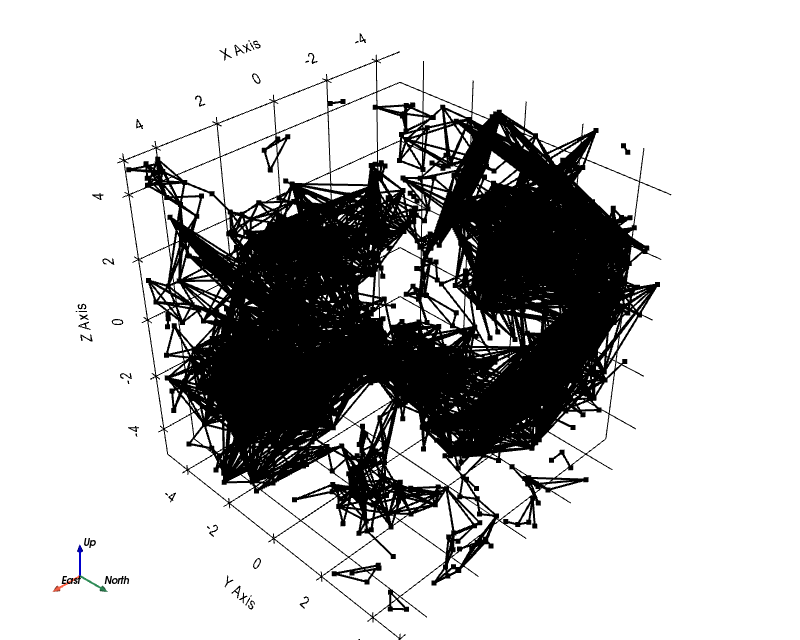

In [4]:
igraph = graphs.IntersectionGraph()
igraph.create(system)
print("Number of nodes in igraph = {}".format(igraph.numVertex())) 

plot_graph(igraph)

The intersection graph can also be created directly from the fracture graph:
```python
igraph = graphs.IntersectionGraph()
igraph.create(fgraph)
```

We define permeameter conditions for flow computations.

In [5]:
import dfnlab.FlowBoundaryConditions as bc
import numpy as np

bc.FlowBoundaryCondition.setPermeameter(domain=domain,head1=10,head2=0,direction=np.array([0,1,0]))

And integrate them in our graphs.

In [6]:
fgraph.integrateBoundaryConditions("flow")
print("Number of nodes in fgraph = {}".format(fgraph.numVertex())) 
igraph.integrateBoundaryConditions("flow")
print("Number of nodes in fgraph = {}".format(igraph.numVertex())) 

Number of nodes in fgraph = 727
Number of nodes in fgraph = 987


Fracture transmissivities must be added to the graphs. They must be constant by fracture. In this example, we choose $T=1$ for all fractures.

In [7]:
import dfnlab.MaterialProperties as mat

mat.Transmissivities.setConstant(dfn=fnet, value=1)
fgraph.integrateTransmissivities()
igraph.integrateTransmissivities()

The "keepBackbone" function selects nodes and edges that can "flow" with these boundary conditions. It first removes isolated node clusters (i.e. clusters that are not connected to the two borders with fixed pressure conditions), and secondly the dead-ends (i.e. nodes with only one neighbor, iteratively). 

Num nodes fgraph backbone=412


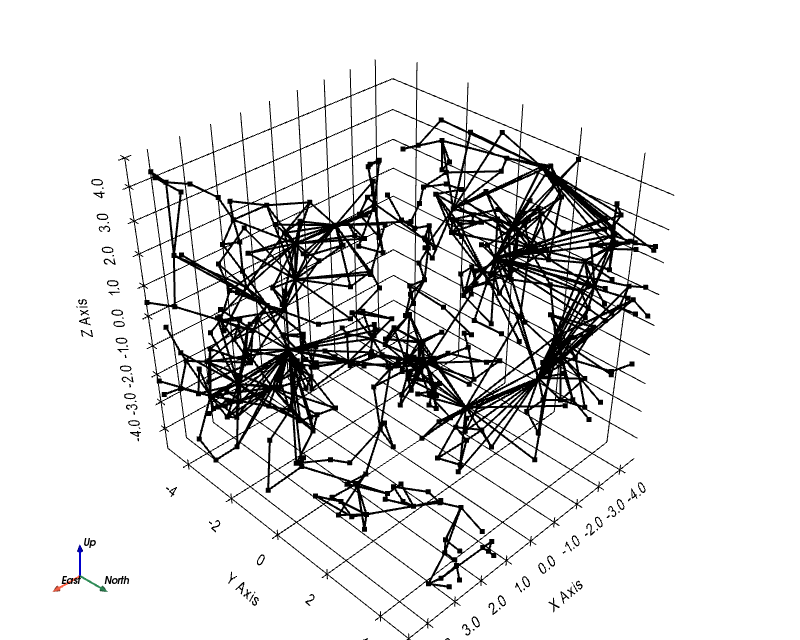

In [8]:
fgraph.keepBackbone()
print("Num nodes fgraph backbone={}".format(fgraph.numVertex())) 
plot_graph(fgraph)

Num nodes igraph backbone=882


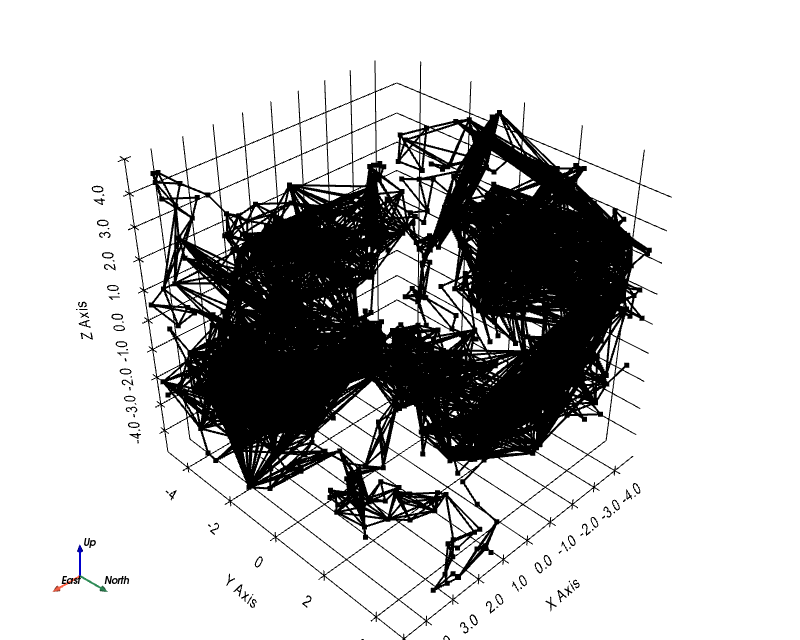

In [9]:
igraph.keepBackbone()
print("Num nodes igraph backbone={}".format(igraph.numVertex())) 
plot_graph(igraph)

It is possible to reconstruct DFN from these graphs, for example here from the fracture graph:

nf backbone=364


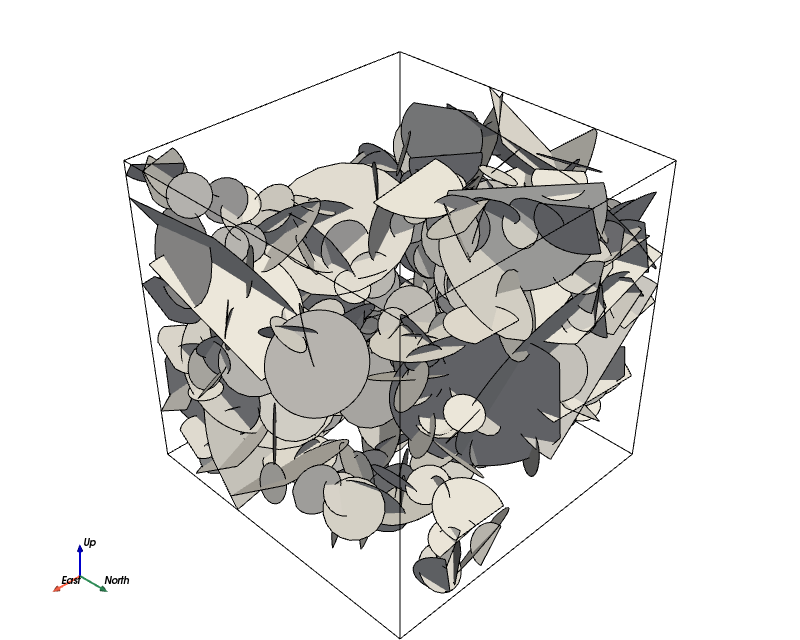

In [10]:
backbone = fgraph.createSystem(update = True)
print("nf backbone={}".format(backbone.getDFN().numFractures()))
plot_dfn(backbone)

## Graph flow solving

We create a _GraphFlow_ object taking either a fracture or intersection graph as input, create the solving matrices, and solve nodes head and edges flow.

We record execution time.

In [11]:
from time import process_time_ns
t = process_time_ns()

fgraphFlow = graphs.GraphFlow(fgraph)
fgraphFlow.createSolvingMatrices()
fgraphFlow.solveHeadAndFlow()

elapsed_time = process_time_ns() - t
print("Solving flow with fracture graph takes {} seconds".format(elapsed_time*1e-9))

Solving flow with fracture graph takes 0.0 seconds


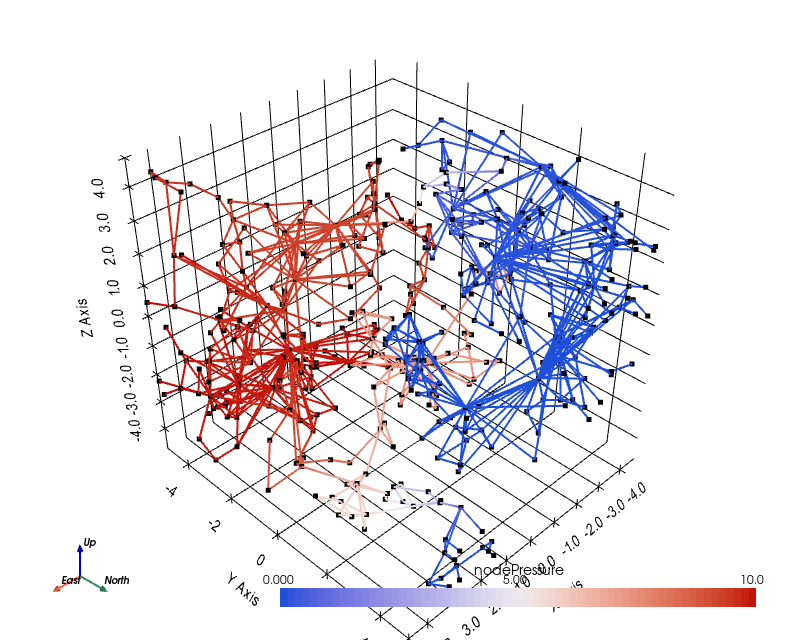

In [12]:
from sources.functions import plot_graph
plot_graph(fgraph,fgraphFlow)

In [13]:
from time import process_time_ns
t = process_time_ns()

igraphFlow = graphs.GraphFlow(igraph)
igraphFlow.createSolvingMatrices()
igraphFlow.solveHeadAndFlow()

elapsed_time = process_time_ns() - t
print("Solving flow with intersection graph takes {} seconds".format(elapsed_time*1e-9))

Solving flow with intersection graph takes 0.046875 seconds


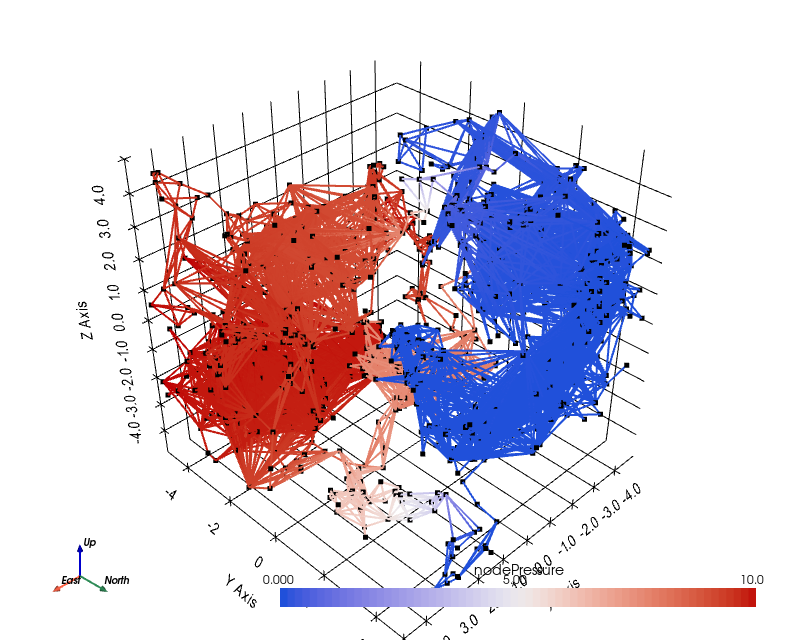

In [14]:
from sources.functions import plot_graph
plot_graph(igraph,igraphFlow)

## Comparison with real DFN flow simulations

We mesh the backbone system and solve the Darcy problem using the DFN.Lab flow solver.

We record execution time.

In [15]:
import dfnlab.Mesh as mesh

mesh = mesh.Mesh(backbone) 
mesh.setCaracteristicLength(5) 
mesh.setRefinementIntersection(2)
mesh.setRefinementFracture(2)
mesh.setGradationCoefficient(2)  
mesh.generate() ;

In [16]:
import dfnlab.Flow as flow

from time import process_time_ns
t = process_time_ns()

flow_system = flow.solveDarcyProblem(mesh)

elapsed_time = process_time_ns() - t
print("Solving flow with mesh takes {} seconds".format(elapsed_time*1e-9))

Linear system building 
Taking account of the boundary conditions
Linear System solving
Solving flow with mesh takes 0.390625 seconds


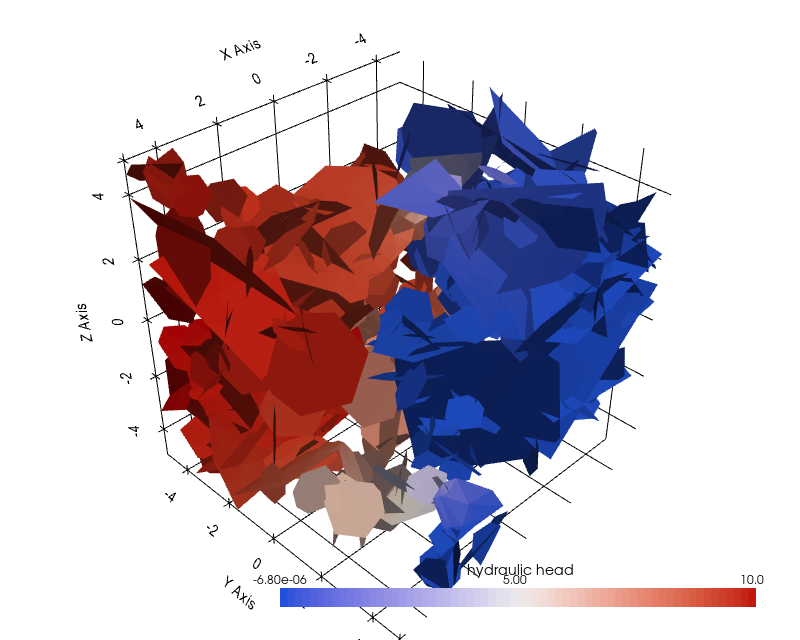

In [17]:
from sources.functions import plot_mesh
plot_mesh(mesh,flow_system.getHead(),"hydraulic head")

It appears that solving flow from a mesh is more than 10 times longer than using a graph. Morevover, we need a mesh, which can also be a long time process.

We compare the equivalent permeability for the various methods used in this tutorial.

In [18]:
K_dfn = flow_system.getIndicatorsValue("hydraulicConductivity")
K_fgraph = fgraphFlow.getHydraulicConductivity()
K_igraph = igraphFlow.getHydraulicConductivity()

print("Permeability from DFN = {}".format(K_dfn))
print("Permeability from fracture graph = {}".format(K_fgraph))
print("Permeability from intersection graph = {}".format(K_igraph))

Permeability from DFN = 0.028931193577887038
Permeability from fracture graph = 0.0366458187823713
Permeability from intersection graph = 0.03092226072332084
